In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
import pmdarima
from pmdarima import auto_arima
from composition_stats import closure
from composition_stats import ilr,ilr_inv
import warnings
warnings.filterwarnings("ignore")

In [56]:
import os 
  
# current directory 
current_dir = os.getcwd() 
relative_path=os.path.abspath(os.path.join(current_dir, os.pardir))

In [57]:
SLR_data = pd.DataFrame(pd.read_csv(
    relative_path+"\\age_structure_data\\SLR2_data.csv"))
SLR_data['Year'] = pd.to_datetime(SLR_data['Year'])
SLR_data =SLR_data.set_index("Year")

In [58]:
test_data= pd.DataFrame(pd.read_csv(
    relative_path+"\\age_structure_data\\df_test.csv"))
test_data['Year'] = pd.to_datetime(test_data['Year'])
test_data = test_data.set_index("Year")

In [59]:
SLR_1=SLR_data['log_ratio_1']
SLR_2=SLR_data['log_ratio_2']

In [60]:
def find_best_pdq(train_data, test_data, d):
    df_search = pd.DataFrame()
    for p in range(6):
            for q in range(6):
                arima_model = ARIMA(train_data, order=(p, d, q)).fit()
                # predict from the position of test data which is length of train data
                prediction = arima_model.predict(
                    start=len(train_data), end=len(train_data)+len(test_data)-1)
                rmse = sqrt(mean_squared_error(test_data, prediction))
                df_search = df_search.append({'pdq_paramters': str(
                    p)+" "+str(d)+" "+str(q), 'rmse': rmse}, ignore_index=True)
    return df_search, test_data, prediction

For SLR_1

In [61]:
train_e_1, test_e_1 = train_test_split(SLR_1, test_size=0.2, shuffle=False)
train_e_2, test_e_2 = train_test_split(train_e_1, test_size=0.2, shuffle=False)
train_e_3, test_e_3 = train_test_split(train_e_2, test_size=0.15, shuffle=False)
log_ratio_e_best_pdq1, test_data_e_1, prediction_test_e_1=find_best_pdq(train_e_1, test_e_1, 2)
log_ratio_e_best_pdq2, test_data_e_2, prediction_test_e_2=find_best_pdq(train_e_2, test_e_2, 2)
log_ratio_e_best_pdq3, test_data_e_3, prediction_test_e_3=find_best_pdq(train_e_3, test_e_3, 2)

concatenated_1 = pd.concat([log_ratio_e_best_pdq1, log_ratio_e_best_pdq2, log_ratio_e_best_pdq3])
concatenated_1=concatenated_1.groupby('pdq_paramters').mean()
concatenated_1.sort_values('rmse', ascending=True).head()

,rmse
pdq_paramters,
2 2 2,0.008496
3 2 4,0.016497
4 2 4,0.016846
2 2 4,0.017096
1 2 4,0.017224


In [62]:
arima_model_1 = ARIMA(SLR_1, order=(2, 2, 2)).fit()
prediction_1 = arima_model_1.predict(
    start=len(SLR_1), end=len(SLR_1)+len(test_data)-1)
prediction_1 = prediction_1.to_frame()
prediction_1.rename(columns = {'predicted_mean':0}, inplace = True)
final_1 = pd.concat([SLR_1, prediction_1])

For SLR_y

In [63]:
train_y_1, test_y_1 = train_test_split(SLR_2, test_size=0.2, shuffle=False)
train_y_2, test_y_2 = train_test_split(train_y_1, test_size=0.2, shuffle=False)
train_y_3, test_y_3 = train_test_split(train_y_2, test_size=0.15, shuffle=False)
log_ratio_y_best_pdq1, test_data_y_1, prediction_test_y_1=find_best_pdq(train_y_1, test_y_1, 2)
log_ratio_y_best_pdq2, test_data_y_2, prediction_test_y_2=find_best_pdq(train_y_2, test_y_2, 2)
log_ratio_y_best_pdq3, test_data_y_3, prediction_test_y_3=find_best_pdq(train_y_3, test_y_3, 2)

concatenated_1 = pd.concat([log_ratio_y_best_pdq1, log_ratio_y_best_pdq2, log_ratio_y_best_pdq3])
concatenated_1=concatenated_1.groupby('pdq_paramters').mean()
concatenated_1.sort_values('rmse', ascending=True).head()

,rmse
pdq_paramters,
3 2 4,0.018475
0 2 3,0.018476
5 2 1,0.018514
3 2 5,0.018554
5 2 0,0.018643


In [64]:
arima_model_2 = ARIMA(SLR_2, order=(3,2, 4)).fit()
prediction_2 = arima_model_2.predict(
    start=len(SLR_2), end=len(SLR_2)+len(test_data)-1)
prediction_2 = prediction_2.to_frame()
prediction_2.rename(columns = {'predicted_mean':0}, inplace = True)
final_2 = pd.concat([SLR_2, prediction_2])

Combine parts

In [65]:
final_1.rename(columns = {0:'log_ratio_1'}, inplace = True)
final_2.rename(columns = {0:'log_ratio_2'}, inplace = True)


In [66]:
def SLR2_inv(df1,df2):
    arr_1 = df1.to_numpy()
    arr_2 = df2.to_numpy()
    log_ratio_1 = pd.DataFrame(arr_1,columns=['log_ratio_1'])
    log_ratio_2 = pd.DataFrame(arr_2,columns=['log_ratio_2'])
    e2_arr=[]
    y2_arr=[]
    k2_arr=[]
    for i in range(len(df1)):
        A = log_ratio_1._get_value(i,0,takeable = True)
        B = log_ratio_2._get_value(i,0,takeable = True)
        e2_arr.append(1)
        y2_arr.append(1/(10**A))
        k2_arr.append(1/(10**B))
    e_prepro = pd.DataFrame(e2_arr, columns=['e_prepro'])
    y_prepro = pd.DataFrame(y2_arr, columns=['y_prepro'])
    k_prepro = pd.DataFrame(k2_arr, columns=['k_prepro'])
    prepro = pd.concat([e_prepro, y_prepro,k_prepro],axis=1)
    data_proportion = closure(prepro)
    return data_proportion


In [67]:
data_proportion=SLR2_inv(final_1,final_2)

In [68]:
def set_col(df):
    df = pd.DataFrame(df, columns=[
    'elder', 'youth', 'kid'])
    df['Year'] = df.index + 1964
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    df = df.set_index("Year")
    return df

In [69]:
proportion = set_col(data_proportion)

In [70]:
df_actual=proportion[(proportion.index< '2010-01-01')]
df_forecast=proportion[(proportion.index> '2009-01-01')]

In [71]:
proportion_actual_1=SLR2_inv(test_data_e_1, test_data_y_1)
proportion_actual_2=SLR2_inv(test_data_e_2, test_data_y_2)
proportion_actual_3=SLR2_inv(test_data_e_3, test_data_y_3)
proportion_forecast_1=SLR2_inv(prediction_test_e_1, prediction_test_y_1)
proportion_forecast_2=SLR2_inv(prediction_test_e_2, prediction_test_y_2)
proportion_forecast_3=SLR2_inv(prediction_test_e_3, prediction_test_y_3)

In [72]:
rmse1 = sqrt(mean_squared_error(proportion_actual_1, proportion_forecast_1))
rmse2 = sqrt(mean_squared_error(proportion_actual_2, proportion_forecast_2))
rmse3 = sqrt(mean_squared_error(proportion_actual_3, proportion_forecast_3))

rmse_cv=(rmse1+rmse2+rmse3)/3
rmse_cv

0.0035039023831115006

In [73]:
rmse_final = sqrt(mean_squared_error(df_forecast, test_data))
rmse_final

0.006338441526411446

In [74]:
test_data

,elder,youth,kid
Year,,,
2010-01-01,0.049382,0.671007,0.279611
2011-01-01,0.051145,0.675869,0.272987
2012-01-01,0.053118,0.679910,0.266972
2013-01-01,0.055259,0.683400,0.261341
2014-01-01,0.057486,0.686543,0.255971
2015-01-01,0.059756,0.689348,0.250896
2016-01-01,0.062031,0.690806,0.247163
2017-01-01,0.064340,0.692223,0.243438
2018-01-01,0.066718,0.693331,0.239951


In [75]:
df_forecast.to_csv(relative_path+"\\age_structure_data\\grid_SLR2_forecast.csv")

In [76]:
df_forecast

,elder,youth,kid
Year,,,
2010-01-01,0.049311,0.670817,0.279872
2011-01-01,0.050124,0.675067,0.274809
2012-01-01,0.051157,0.678403,0.270440
2013-01-01,0.052283,0.681059,0.266658
2014-01-01,0.053320,0.683858,0.262822
2015-01-01,0.054205,0.687510,0.258284
2016-01-01,0.055027,0.691844,0.253128
2017-01-01,0.055922,0.695925,0.248152
2018-01-01,0.056953,0.699057,0.243990


<function matplotlib.pyplot.show(close=None, block=None)>

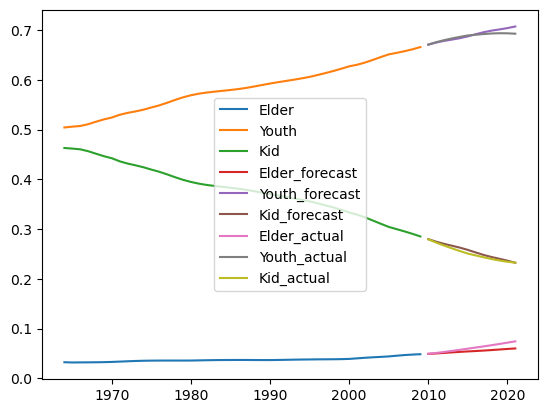

In [77]:
plt.plot(df_actual['elder'],label="Elder")
plt.plot(df_actual['youth'],label="Youth")
plt.plot(df_actual['kid'],label="Kid")
plt.plot(df_forecast['elder'],label="Elder_forecast")
plt.plot(df_forecast['youth'],label="Youth_forecast")
plt.plot(df_forecast['kid'],label="Kid_forecast")

plt.plot(test_data['elder'],label="Elder_actual")
plt.plot(test_data['youth'],label="Youth_actual")
plt.plot(test_data['kid'],label="Kid_actual")


plt.legend(loc='best')
plt.show

In [78]:
residual = pd.DataFrame(test_data-df_forecast)

In [79]:
residual

,elder,youth,kid
Year,,,
2010-01-01,0.000070,0.000190,-0.000261
2011-01-01,0.001020,0.000802,-0.001822
2012-01-01,0.001961,0.001507,-0.003468
2013-01-01,0.002975,0.002341,-0.005317
2014-01-01,0.004166,0.002686,-0.006851
2015-01-01,0.005550,0.001838,-0.007388
2016-01-01,0.007004,-0.001038,-0.005966
2017-01-01,0.008417,-0.003703,-0.004715
2018-01-01,0.009765,-0.005726,-0.004039


<AxesSubplot:ylabel='Density'>

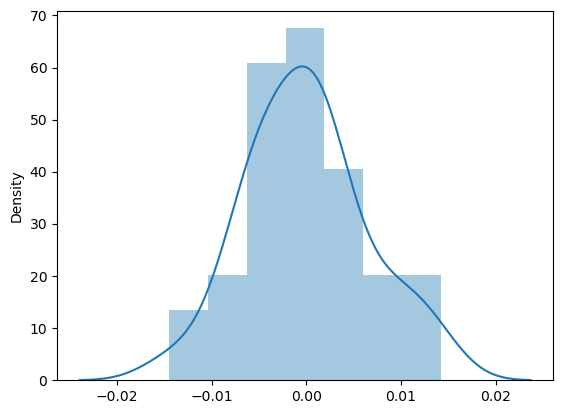

In [80]:
import seaborn as sns

sns.distplot(residual,kde=True)

<AxesSubplot:xlabel='kid', ylabel='Density'>

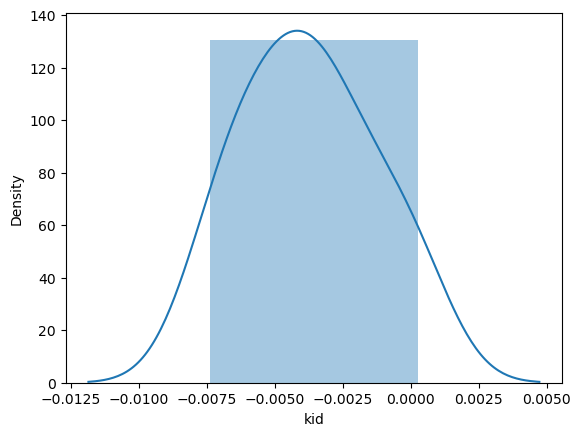

In [81]:
sns.distplot(residual['kid'],kde=True)
          

<AxesSubplot:xlabel='youth', ylabel='Density'>

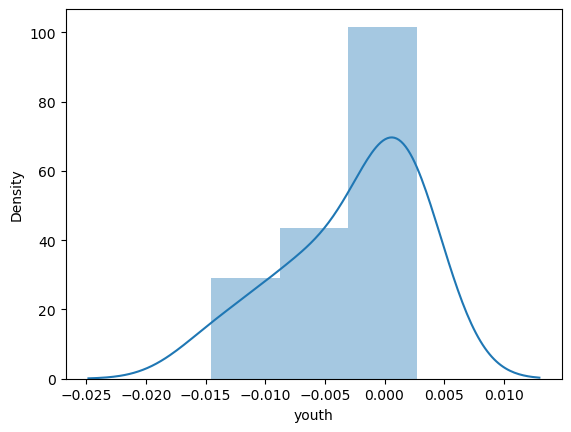

In [82]:
sns.distplot(residual['youth'],kde=True)

<AxesSubplot:xlabel='elder', ylabel='Density'>

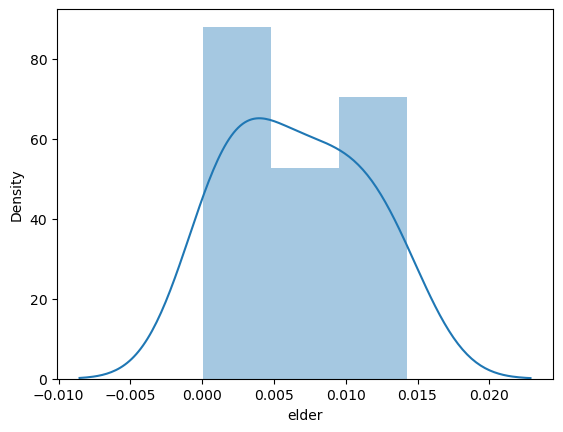

In [83]:
sns.distplot(residual['elder'],kde=True)